# Assignment 2 : Probabilistic Graphical Models
##Paul Martin & Samuel Diai
___

We load an image and apply a gaussian noise on it :

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from numba import jit

img=mpimg.imread('drive/MyDrive/spiral.png')[:, :, 0]
h, w = img.shape
noise = np.random.normal(0, 0.5, (h, w)) 
#noise = np.random.randn((h, w))
noisy_img = img + noise

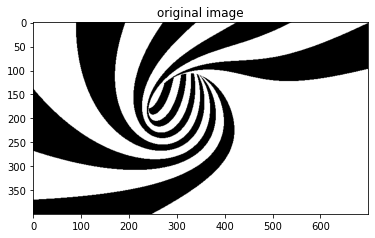

In [ ]:
plt.imshow(img, cmap='gray')
plt.title('original image')
plt.show()

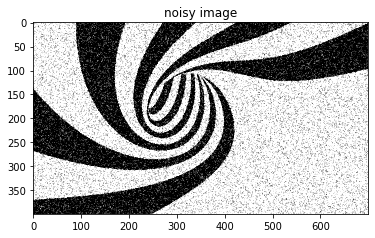

In [ ]:
plt.imshow(noisy_img, cmap='gray', vmin = 0, vmax = 1)
plt.title('noisy image')
plt.show()

## Question 1 : Beliefs propagation
___

We write the probability distribution we want to sample from : 
$$ p(x | y) = \frac{p(x, y)}{p(y)} =  \frac{p(y | x)p(x)}{p(y)} \propto p(y | x)p(x)$$

As for each $i$, $y_i$ only depends on $x_i$ : $$ p(y | x) = \prod_{i = 1}^n p(y_i| x_i) = \prod_{i = 1}^n \mathcal{N}(y_i; \mu_{x_i}, 1)$$ 

Where $\mathcal{N}(y_i; \mu_{x_i}, 1)$ if the pdf of the gaussian distibution of mean $\mu_{x_i}$ and variance $1$.


Thus :
$$ p(x | y) \propto \prod_{i = 1}^n \mathcal{N}(y_i; \mu_{x_i}, 1) \exp\left\{  \sum_{i = 1}^n \left[\alpha x_i + \beta \sum_{j \in \mathcal{N}(i)}\mathbb{1}(x_i = x_j) \right]\right\} 	$$


$$ p(x | y) \propto \exp\left\{  \sum_{i = 1}^n \left[-\frac{1}{2}(y_i - \mu_{x_i})^2 + \alpha x_i + \beta \sum_{j \in \mathcal{N}(i)}\mathbb{1}(x_i = x_j) \right]\right\}$$


In the general case, the loopy belief algorithm writes for a pixel $x_k$:

$$p(x_k) \propto \phi_k(x_k) \prod_{j \in \mathcal{N}(k)} \mu_{j \mapsto k}(x_k) $$

Where the messages must be propagated as : 
$$\mu_{j \mapsto k}(x_k) =  \sum_{x_j} \phi_{jk}(x_j, x_k)\phi_j(x_j) \prod_{i \in \mathcal{N}(j) \setminus \{ k \}} \mu_{i \mapsto j}(x_j) $$

In the 2D case, let's indicate by $ij$ the coordinate of a node. The neighbours of a pixel of coordinates $(i, j)$ are the pixels of coordinates $(i-1, j)$, $(i+1, j)$, $(i, j-1)$, $(i, j+1)$.
The formula writes : 
$$ p(x | y) \propto \exp\left\{  \sum_{i = 1}^w \sum_{j = 1}^h \left[-\frac{1}{2}(y_{i,j} - \mu_{x_{i,j}})^2 + \alpha x_{i,j}  + \beta \mathbb{1}(x_{i,j} = x_{i - 1,j}) + \beta \mathbb{1}(x_{i,j} = x_{i + 1,j}) + \beta \mathbb{1}(x_{i,j} = x_{i,j - 1}) + \beta \mathbb{1}(x_{i,j} = x_{i,j + 1})\right]\right\}$$



We can thus apply the lbp algorithm.

We define the potential : $$\Phi_{i, j}(x_{i, j}) = \exp\left\{-\frac{1}{2}(y_{i,j} - \mu_{x_{i,j}})^2 + \alpha x_{i,j}\right\} = \exp\left\{-\frac{1}{2}(y_{i,j} - \mu_0 \mathbb{1}(x_{i,j} = 0)- \mu_1\mathbb{1}(x_{i,j} = 1))^2 + \alpha x_{i,j}\right\}$$

And we update the messages as : 

$$\mu_{i - 1, j \mapsto i,j}(x_{i,j}) = \sum_{x_{i - 1,j}} \exp \left\{\beta \mathbb{1}(x_{i,j} = x_{i - 1,j})\Phi_{i - 1,j}(x_{i - 1, j})\mu_{i - 1, j + 1 \mapsto i-1,j}(x_{i - 1, j})\mu_{i - 1, j-1 \mapsto i-1,j}(x_{i - 1, j})\mu_{i - 2, j \mapsto i - 1,j}(x_{i - 1, j})\right\}$$

$$\mu_{i + 1, j \mapsto i,j}(x_{i,j}) = \sum_{x_{i + 1,j}} \exp \left\{\beta \mathbb{1}(x_{i,j} = x_{i + 1,j})\Phi_{i + 1, j}(x_{i + 1, j})\mu_{i + 1, j + 1 \mapsto i+1,j}(x_{i + 1, j})\mu_{i + 1, j-1 \mapsto i+1,j}(x_{i + 1, j})\mu_{i + 2, j \mapsto i + 1,j}(x_{i + 1, j})\right\}$$

$$\mu_{i, j - 1 \mapsto i,j}(x_{i,j}) = \sum_{x_{i,j-1}} \exp \left\{\beta \mathbb{1}(x_{i,j} = x_{i,j-1})\Phi_{i, j-1}(x_{i, j-1})\mu_{i - 1, j - 1 \mapsto i,j-1}(x_{i, j-1})\mu_{i + 1, j-1 \mapsto i,j-1}(x_{i, j-1})\mu_{i, j-2 \mapsto i ,j-1}(x_{i, j-1})\right\}$$

$$\mu_{i, j + 1 \mapsto i,j}(x_{i,j}) = \sum_{x_{i,j+1}} \exp \left\{\beta \mathbb{1}(x_{i,j} = x_{i,j+1})\Phi_{i,j+1}(x_{i,j+1})\mu_{i - 1, j + 1 \mapsto i,j+1}(x_{i,j+1})\mu_{i + 1, j + 1 \mapsto i,j+1}(x_{i,j+1})\mu_{i, j+2 \mapsto i ,j+1}(x_{i,j+1})\right\}$$

The beliefs can thus be computed : 

$$b[i, j](x_{ij}) = \Phi_{ij}(x_{ij}) \times \mu_{i - 1, j \mapsto i,j}(x_{i,j}) \times \mu_{i + 1, j \mapsto i,j}(x_{i,j}) \times \mu_{i, j - 1 \mapsto i,j}(x_{i,j}) \times \mu_{i, j + 1 \mapsto i,j}(x_{i,j})$$

Let's denote :
* $m_D[i, j]$ the message going **down** to the pixel $(i, j)$
* $m_U[i, j]$ the message going **up** to the pixel $(i, j)$
* $m_R[i, j]$ the message going **right** to the pixel $(i, j)$
* $m_L[i, j]$ the message going **Left** to the pixel $(i, j)$

The above equations then rewrite :

$$m_D[i, j](x_{i,j}) = \sum_{x} \exp \left\{\beta \mathbb{1}(x_{i,j} = x)\Phi_{i - 1,j}(x)m_D[i - 1, j](x)m_R[i - 1, j](x)m_L[i - 1, j](x)\right\}$$

$$m_U[i, j](x_{i,j}) = \sum_{x} \exp \left\{\beta \mathbb{1}(x_{i,j} = x)\Phi_{i + 1,j}(x)m_U[i + 1, j](x)m_R[i + 1, j](x)m_L[i + 1, j](x)\right\}$$

$$m_R[i, j](x_{i,j}) = \sum_{x} \exp \left\{\beta \mathbb{1}(x_{i,j} = x)\Phi_{i,j-1}(x)m_D[i, j-1](x)m_U[i, j-1](x)m_R[i, j-1](x)\right\}$$

$$m_L[i, j](x_{i,j})= \sum_{x} \exp \left\{\beta \mathbb{1}(x_{i,j} = x)\Phi_{i,j+1}(x)m_D[i, j+1](x)m_U[i, j+1](x)m_L[i, j+1](x)\right\}$$

In practice, we store the logarithm of the messages $m^l_D$, $m^l_U$, $m^l_R$, $m^l_L$.

And we define the logarithm of the potential :
 $$\Phi^l_{i, j}(x_{i, j}) = -\frac{1}{2}(y_{i,j} - \mu_{x_{i,j}})^2 + \alpha x_{i,j} = \frac{1}{2}(y_{i,j} - \mu_0 \mathbb{1}(x_{i,j} = 0)- \mu_1\mathbb{1}(x_{i,j} = 1))^2 + \alpha x_{i,j}$$

We can then compute the logarithm of the messages without doing overflows. With the function of a vector $v$ : $\log \text{sum} \exp(v) = \log \sum_i \exp (v_i)$

$$m^l_D[i, j](x_{i,j}) = \log \text{sum} \exp_{x} \left\{\beta \mathbb{1}(x_{i,j} = x) + \Phi_{i - 1,j}(x) + m^l_D[i - 1, j](x) + m^l_R[i - 1, j](x) + m^l_L[i - 1, j](x)\right\}$$

$$m^l_U[i, j](x_{i,j}) = \log \text{sum}\exp_{x} \left\{\beta \mathbb{1}(x_{i,j} = x) + \Phi_{i + 1,j}(x) + m^l_U[i + 1, j](x) + m^l_R[i + 1, j](x) + m^l_L[i + 1, j](x)\right\}$$

$$m^l_R[i, j](x_{i,j}) = \log \text{sum} \exp_{x} \left\{\beta \mathbb{1}(x_{i,j} = x) + \Phi_{i,j-1}(x) + m^l_D[i, j-1](x) + m^l_U[i, j-1](x) + m^l_R[i, j-1](x)\right\}$$

$$m^l_L[i, j](x_{i,j})= \log \text{sum} \exp_{x} \left\{\beta \mathbb{1}(x_{i,j} = x) + \Phi_{i,j+1}(x) + m^l_D[i, j+1](x) + m^l_U[i, j+1](x) + m^l_L[i, j+1](x)\right\}$$

We can compute the logarithm $b^l[i, j]$of the beliefs as : 


$$b^l[i, j](x_{ij}) = \Phi^l_{ij}(x_{ij}) + m^l_D[i, j](x_{i,j}) + m^l_U[i, j](x_{i,j}) + m^l_L[i, j](x_{i,j}) + m^l_R[i, j](x_{i,j})$$

We also implemented the loopy belief propagation with the max-product operations : 
The only difference is to replace the $\log \text{sum} \exp$ function with a $\log \text{max} \exp$ function. And we can notice that : 
$\log \text{max} \exp(v) = \log (\max_i (\exp (v_i))) = \max_i  (\log (\exp (v_i))) = \max_i v_i$ as the logarithm is an increasing function.

The message propagation equations become :
$$m^l_D[i, j](x_{i,j}) = \max_{x} \left\{\beta \mathbb{1}(x_{i,j} = x) + \Phi_{i - 1,j}(x) + m^l_D[i - 1, j](x) + m^l_R[i - 1, j](x) + m^l_L[i - 1, j](x)\right\}$$

$$m^l_U[i, j](x_{i,j}) = \max_{x} \left\{\beta \mathbb{1}(x_{i,j} = x) + \Phi_{i + 1,j}(x) + m^l_U[i + 1, j](x) + m^l_R[i + 1, j](x) + m^l_L[i + 1, j](x)\right\}$$

$$m^l_R[i, j](x_{i,j}) = \max_{x} \left\{\beta \mathbb{1}(x_{i,j} = x) + \Phi_{i,j-1}(x) + m^l_D[i, j-1](x) + m^l_U[i, j-1](x) + m^l_R[i, j-1](x)\right\}$$

$$m^l_L[i, j](x_{i,j})= \max_{x} \left\{\beta \mathbb{1}(x_{i,j} = x) + \Phi_{i,j+1}(x) + m^l_D[i, j+1](x) + m^l_U[i, j+1](x) + m^l_L[i, j+1](x)\right\}$$



## Question 1 : Loopy Belief Propagation
___


In [ ]:
from scipy.special import logsumexp

def compute_cost_log(x, mu_0, mu_1, alpha, y = noisy_img):
    mean_matrix = mu_1 * x + mu_0 * (1 - x)
    return alpha * x - 0.5 * (y - mean_matrix)**2

def compute_log_beliefs(message_down, message_up, message_left, message_right, mu_0, mu_1, alpha,):
    beliefs = np.zeros((h, w, 2))
    beliefs[:, :, 0] = compute_cost_log(np.zeros((h, w)), mu_0, mu_1, alpha) + message_down[:, :, 0] + message_up[:, :, 0] + message_left[:, :, 0] + message_right[:, :, 0]
    beliefs[:, :, 1] = compute_cost_log(np.ones((h, w)), mu_0, mu_1, alpha) + message_down[:, :, 1] + message_up[:, :, 1] + message_left[:, :, 1] + message_right[:, :, 1]
    return beliefs

def shift(key, array,direction):
    '''
    Function allowing to shift an array in a direction.
    key : number of pixel to shift
    array : array we need to shift
    direction : 'right','down','up','left'
    '''
    if key > 0:
        if direction == 'left':
            return np.concatenate((np.ones(array.shape)[:,:key],array[:,:-key]),axis = 1)
        elif direction == 'right':
            return np.concatenate((array[:,key:],np.ones(array.shape)[:,:key]),axis = 1)
        elif direction == 'up':
            return np.concatenate((np.ones(array.shape)[:key,:],array[:-key,:]),axis = 0)
        elif direction == 'down':
            return np.concatenate((array[key:,:],np.ones(array.shape)[:key,:]),axis = 0)
        else:
            raise("Invalid Direction")
    else:
        return array

def update_messages(message_down, message_up, message_left, message_right, mu_0, mu_1, alpha, beta, algo_type):  
    msgd_ = message_down + message_left + message_right
    msgd_0 = shift(1, compute_cost_log(0, mu_0, mu_1, alpha) + msgd_[:, :, 0], 'down')
    msgd_1 = shift(1, compute_cost_log(1, mu_0, mu_1, alpha) + msgd_[:, :, 1], 'down')
    if algo_type == 'sum-product':
        message_down[:, :, 0] = np.logaddexp(beta + msgd_0, msgd_1)
        message_down[:, :, 1] = np.logaddexp(msgd_0, beta + msgd_1)
    else : 
        message_down[:, :, 0] = np.maximum(beta + msgd_0, msgd_1)
        message_down[:, :, 1] = np.maximum(msgd_0, beta + msgd_1)


    mesgu_ = message_up + message_left + message_right
    msgu_0 = compute_cost_log(0, mu_0, mu_1, alpha) + shift(1,  mesgu_[:, :, 0], 'up')
    msgu_1 = compute_cost_log(1, mu_0, mu_1, alpha) + shift(1,  mesgu_[:, :, 1], 'up')
    if algo_type == 'sum-product':
        message_up[:, :, 0] = np.logaddexp(beta + msgu_0, msgu_1)
        message_up[:, :, 1] = np.logaddexp(msgu_0, beta + msgu_1)
    else :
        message_up[:, :, 0] = np.maximum(beta + msgu_0, msgu_1)
        message_up[:, :, 1] = np.maximum(msgu_0, beta + msgu_1)

    mesgl_ = message_down + message_left + message_up
    mesgl_0 = compute_cost_log(0, mu_0, mu_1, alpha) + shift(1,  mesgl_[:, :, 0] , 'left')
    mesgl_1 = compute_cost_log(1, mu_0, mu_1, alpha) + shift(1,  mesgl_[:, :, 1], 'left')
    if algo_type == 'sum-product':
        message_left[:, :, 0] =  np.logaddexp(beta + mesgl_0, mesgl_1)
        message_left[:, :, 1] = np.logaddexp(mesgl_0, beta + mesgl_1)
    else :
        message_left[:, :, 0] =  np.maximum(beta + mesgl_0, mesgl_1)
        message_left[:, :, 1] = np.maximum(mesgl_0, beta + mesgl_1)


    msgr_ = message_down + message_up + message_right
    msgr_0 = compute_cost_log(0, mu_0, mu_1, alpha) + shift(1,  msgr_[:, :, 0], 'right')
    msgr_1 = compute_cost_log(1, mu_0, mu_1, alpha) + shift(1,  msgr_[:, :, 1], 'right')
    if algo_type == 'sum-product':
        message_right[:, :, 0] = np.logaddexp(beta + msgr_0, msgr_1)
        message_right[:, :, 1] = np.logaddexp(msgr_0, beta + msgr_1)      
    else :               
        message_right[:, :, 0] = np.maximum(beta + msgr_0, msgr_1)
        message_right[:, :, 1] = np.maximum(msgr_0, beta + msgr_1)  

    #M = np.logaddexp(compute_cost_log(0) + (message_down + message_left + message_up + message_right)[:, :, 0], compute_cost_log(1) + (message_down + message_left + message_up + message_right)[:, :, 1])[:, :, None]
    #M = np.dstack([compute_cost_log(0), compute_cost_log(1)]) + (message_down + message_left + message_up + message_right)/4
    M = np.concatenate([message_down, message_up, message_left, message_right]).mean()
    message_down -= M
    message_up -= M
    message_left -= M
    message_right -= M
    
    return message_down, message_up, message_left, message_right


def LBP(n_iter, mu_0 = 0, mu_1 = 1, alpha = 0, beta = 5, algo_type = 'max-sum'):
    list_images = []
    list_iter = []
    message_down = np.random.rand(h, w, 2)
    message_up = np.random.rand(h, w, 2)
    message_left = np.random.rand(h, w, 2)
    message_right = np.random.rand(h, w, 2)
    for _ in range(n_iter):
        message_down, message_up, message_left, message_right = update_messages(message_down, message_up, message_left, message_right, mu_0, mu_1, alpha, beta, algo_type)
        beliefs = compute_log_beliefs(message_down, message_up, message_left, message_right, mu_0, mu_1, alpha)
        if _%1 == 0:
            list_images.append(beliefs)
            list_iter.append(_)
    return list_images, list_iter


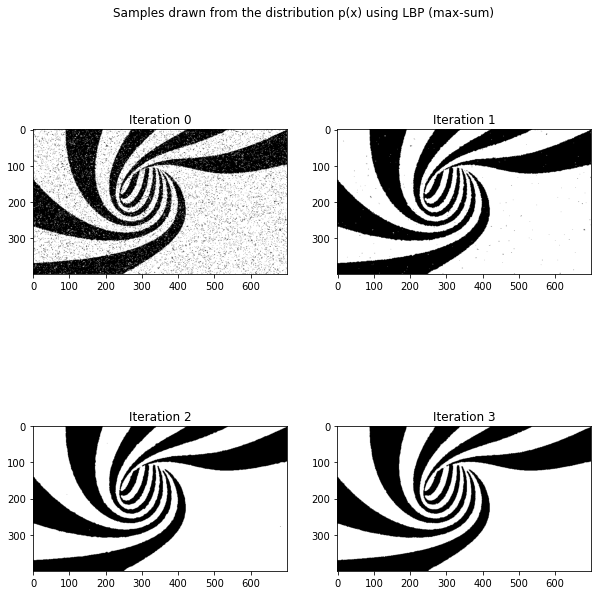

In [ ]:
list_images, list_iter = LBP(n_iter = 4, mu_0 = 0, mu_1 = 1, alpha = 0, beta = 5, algo_type = 'max-sum')
fig, ax = plt.subplots(2, 2, figsize = (10, 10))
for idx, img in enumerate(list_images):
    ax[idx // 2, idx %2].imshow(img.argmax(axis = 2), cmap = 'gray', vmin = 0, vmax = 1)
    ax[idx // 2, idx %2].set_title('Iteration %s' % list_iter[idx])
fig.suptitle('Samples drawn from the distribution p(x) using LBP (max-sum)')
plt.show()

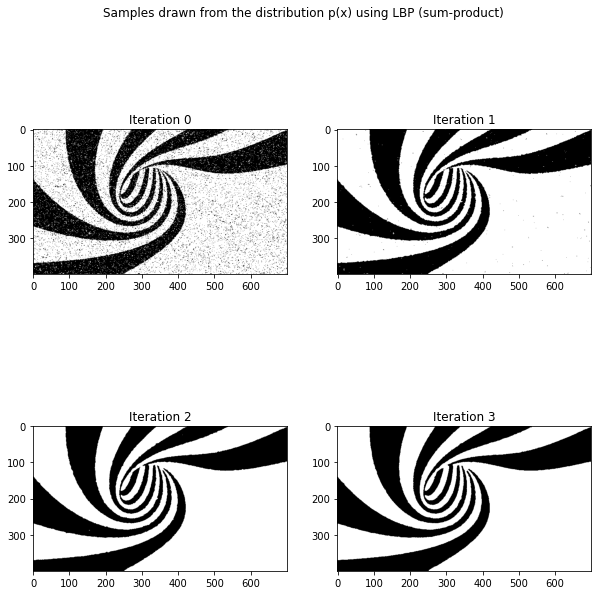

In [ ]:
list_images, list_iter = LBP(n_iter = 4, mu_0 = 0, mu_1 = 1, alpha = 0, beta = 5, algo_type = 'sum-product')
fig, ax = plt.subplots(2, 2, figsize = (10, 10))
for idx, img in enumerate(list_images):
    ax[idx // 2, idx %2].imshow(img.argmax(axis = 2), cmap = 'gray', vmin = 0, vmax = 1)
    ax[idx // 2, idx %2].set_title('Iteration %s' % list_iter[idx])
fig.suptitle('Samples drawn from the distribution p(x) using LBP (sum-product)')
plt.show()


Even if in theory we don't have any convergence guaranties, the Loopy Belief Algorithm seems to converge really fast (4 iterations).

## Question 2 : Gibbs Sampling (MCMC method) 
___

We want to sample according to the following distribution : $p(x_i|x_{-i}, y)$.

As we have seen in the previous question :

$$ p(x | y) \propto \exp\left\{  \sum_{i = 1}^n \left[-\frac{1}{2}(y_i - \mu_{x_i})^2 + \alpha x_i + \beta \sum_{j \in \mathcal{N}(i)}\mathbb{1}(x_i = x_j) \right]\right\}$$

Thus :

$$ p(x_i | y, x_{-i}) \propto \exp\left\{ \left[-\frac{1}{2}(y_i - \mu_{x_i})^2 + \alpha x_i + \beta \sum_{j \in \mathcal{N}(i)}\mathbb{1}(x_i = x_j) \right]\right\}$$

We have : 
$$ p(x_i = 1 | y, x_{-i}) = \frac{p(x_i = 1 | y, x_{-i})}{p(x_i = 1 | y, x_{-i}) + p(x_i = 0 | y, x_{-i})} = \frac{1}{1 + \frac{p(x_i = 0 | y, x_{-i})}{p(x_i = 1 | y, x_{-i})}}$$



 $$ p(x_i = 1 | y, x_{-i}) = \frac{1}{1 + \exp \left\{  -\frac{1}{2}(y_i - \mu_{0})^2 + \frac{1}{2}(y_i - \mu_{1})^2 - \alpha - \beta \sum_{j\in Ne(i)} \mathbb{1}(x_j = 1) + \beta \sum_{j\in Ne(i)} \mathbb{1}(x_j=0)\right\} }$$
 

 $$ p(x_i = 1 | y, x_{-i}) = \sigma \left(  \frac{1}{2}(y_i - \mu_{0})^2 - \frac{1}{2}(y_i - \mu_{1})^2 + \alpha + \beta \sum_{j\in Ne(i)} \mathbb{1}(x_j = 1) - \beta \sum_{j\in Ne(i)} \mathbb{1}(x_j=0)\right) , \text{ where $\sigma$ is the sigmoid function} $$ 
 


The point $i$ can have 2,3 or 4 neighbours depending of its position on the image, by denoting $n_i$ the number of neighbours of point $i$ we can re-write the previous equation using $\mathbb{1}(x_j=0) = 1 - \mathbb{1}(x_j=1)$ : 

$$p(x_i = 1|x_{-i}, y) = \sigma(\alpha + 2(\beta \sum_{j\in Ne(i)} \mathbb{1}(x_j = 1) - \frac{n_i}{2}))$$

We have also using the same properties :

$$p(x_i = 0|x_{-i}, y) = \sigma(-\alpha - 2(\beta \sum_{j\in Ne(i)} \mathbb{1}(x_j = 1) - \frac{n_i}{2}))$$

In order to sample $p(x_i = 1|x_{-i}, y)$, we can do it easily by sampling a random variable following a Bernoulli law with the parameters defined previously (and normalizing them). This parameters depend only of the variables $y$, the neighbours' point of $x_i$ which are known. In a first time, the parameters $(\mu_0, \mu_1, \alpha, \beta)$ are in fact hyper-parameters defined by the user. 

We recall the algorithm of Gibbs sampling for a image :

  **Pseudo code :**

- Initialize $X = X_0$
- For $n=0$ to $n_{iter}$
  + For $i=1$ to $I_{height}$
    + For $j=0$ to $I_{width}$
      + $X(i,j) = \mathcal{B}(p)$, avec $p = p(x_i = 1|x_{-i}, y)$
- Return X



In [ ]:
@jit(nopython=True)
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

@jit(nopython=True)
def sample_xi(y, mu_0, mu_1, x, alpha, beta):
    p = np.zeros((h, w))
    for i in range(h):
        for j in range(w):
            exp_term = alpha + 0.5*((y[i, j] - mu_0)**2 - (y[i, j] - mu_1)**2)
            if i == 0 and j == 0:
                factor =  2 * beta * (x[1, 0] + x[0, 1]  - 1)

            elif i == h-1 and j == 0:
                factor = 2 * beta * (x[h-2, 0] + x[h-1, 1]  - 1)

            elif i == 0 and j == w-1:
                factor = 2 * beta * (x[0, w-2] + x[1, w-1]  - 1)

            elif i == h-1 and j == w-1:
                factor = 2 * beta * (x[h-1, w-2] + x[h-2, w-1]  - 1)

            elif i==0:
              factor = 2 * beta * (x[i, j-1] + x[i, j+1] + x[i+1, j] - 3/2)

            elif i==h-1:
              factor = 2 * beta * (x[i, j-1] + x[i, j+1] + x[i-1, j] - 3/2)

            elif j==0:
              factor = 2 * beta * (x[i-1, j] + x[i+1, j] + x[i, j+1] - 3/2)

            elif j==w-1:
              factor = 2 * beta * (x[i-1, j] + x[i+1, j] + x[i, j-1] - 3/2)

            else:
              factor = 2 * beta * (x[i-1, j] + x[i+1, j] + x[i, j-1] + x[i, j+1] - 2)
            factor += exp_term
            p1 = sigmoid(factor)
            p[i, j] = np.random.binomial(1, p1)
    return p

@jit(nopython=True)
def Gibbs_sampling(burn_in, n_iter, X0, y, mu_0, mu_1, alpha, beta):
  # paramaters
  X_chain = np.empty((n_iter+1, X0.shape[0], X0.shape[1]))
  X = X0.copy().astype(np.float64)
  # iterations
  for i in range(n_iter):
    X = sample_xi(y, mu_0, mu_1, X, alpha, beta)
    X_chain[i+1] = X
  return np.rint(X_chain[burn_in:])


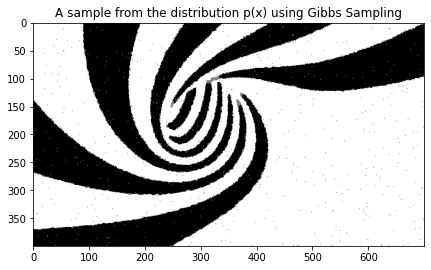

In [ ]:
distrib = Gibbs_sampling(900, 1000, np.random.binomial(1, 0.5, (h, w)), noisy_img, mu_0 = 0, mu_1 = 1, alpha = 0.03, beta = 1.5)
fig, ax = plt.subplots(figsize = (7, 7))
ax.imshow(distrib[-1], cmap = 'gray')
ax.set_title('A sample from the distribution p(x) using Gibbs Sampling');

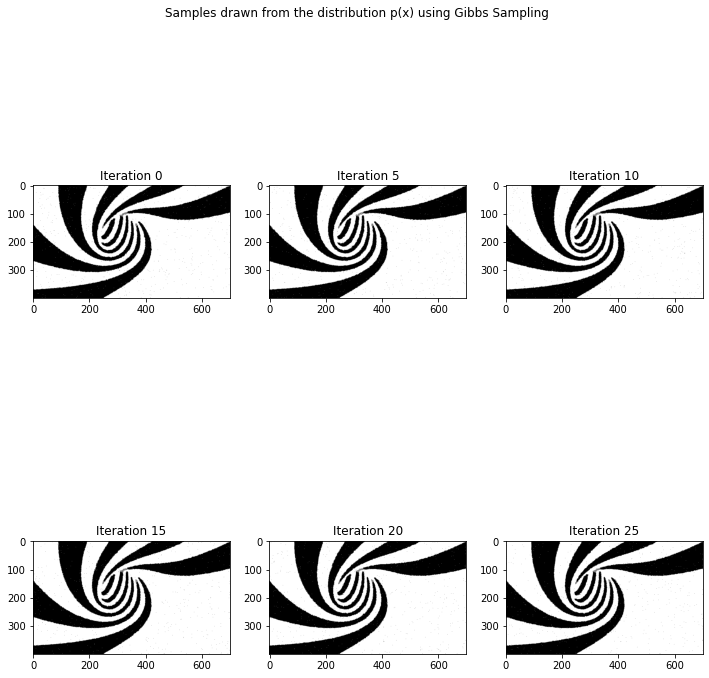

In [ ]:
fig, ax = plt.subplots(2, 3, figsize = (12, 12))
for idx, img in enumerate(distrib[::10]):
    if idx < 6:
      ax[idx //3, idx % 3].imshow(distrib[idx], cmap = 'gray', vmin = 0, vmax = 1)
      ax[idx //3, idx % 3 ].set_title('Iteration %s' % (5 * idx))
    else :
      break
fig.suptitle('Samples drawn from the distribution p(x) using Gibbs Sampling')
plt.show()

## Question 3 : EM algorithm
___

As we described in the first assignment, the EM algorithm consists in :

Iteratively compute $$\theta_{t+1} = \text{argmax}_\theta Q(\theta, \theta_t)$$

Where $(\theta_{t})_t$ is a sequence of parameters we try to learn and fit our data to. We need to do two steps : 
* Expectation : 
    given $\theta_t$, compute $Q(\theta, \theta_t) = \mathbb{E}_x\left[\mathcal{L}((x_i, y_i)_i;\theta)|\theta_t, (y_i)_i \right]$
* Maximization : 
    find $\theta_{t+1} = \text{argmax}_\theta Q(\theta, \theta_t)$


In our case, we denote $\theta = (\mu_0, \mu_1)$. 
We have $p(x, y) = p(y|x)p(x)$
And we can write the log-likelihood of the model :
$$ \mathcal{L}((x_i, y_i)_i;\theta)  = \log(p(x, y; \theta)) = \sum_{i = 1}^n \left[\alpha x_i -\frac{1}{2}(y_i - \mu_0\mathbb{1}(x_i = 0) - \mu_1\mathbb{1}(x_i = 1))^2+ \beta \sum_{j \in \mathcal{N}(i)}\mathbb{1}(x_i = x_j) \right]$$

Thus for the expectation step :

$Q(\theta, \theta_t) = \mathbb{E}_x\left[\mathcal{L}((x_i, y_i)_i;\theta)|\theta_t, (y_i)_i \right] = \sum_{i = 1}^n \left[\alpha \mathbb{E}_x(x_i) -\frac{1}{2}\mathbb{E}_x[(y_i - \mu_0\mathbb{1}(x_i = 0) - \mu_1\mathbb{1}(x_i = 1)))^2] + \beta \sum_{j \in \mathcal{N}(i)}\mathbb{E}_x[\mathbb{1}(x_i = x_j)] \right]$

By developping the product and taking the expectation : 
$$Q(\theta, \theta_t) = \mathbb{E}_x\left[\mathcal{L}((x_i, y_i)_i;\theta)|\theta_t, (y_i)_i \right] = \sum_{i = 1}^n \left[\alpha \mathbb{P}_x(x_i = 1|\theta_t, y) + \beta \sum_{j \in \mathcal{N}(i)}\mathbb{P}_x(x_i = x_j|\theta_t, y)\right]-\frac{1}{2}\sum_{i = 1}^n \left[y_i^2 + \mathbb{P}_x(x_i = 0|\theta_t, y)\mu_0(\mu_0 - 2y_i) + \mathbb{P}_x(x_i = 1|\theta_t, y)\mu_1(\mu_1 - 2y_i)]  \right]$$

For the maximization step (find $\theta_{t+1} = \text{argmax}_\theta Q(\theta, \theta_t)$):

We write the first order conditions on $\mu_0$ and $\mu_1$ :
$$\begin{cases}\frac{\partial \mathcal{L}}{\partial \mu_0} = 0\\
\frac{\partial \mathcal{L}}{\partial \mu_1} = 0\\
\end{cases}$$

We get : 
$$\begin{cases}\mu_0^{t+1} = \frac{\sum_{i = 1}^ny_i\mathbb{P}_x(x_i = 1|\theta_t, y)}{\sum_{i = 1}^n\mathbb{P}_x(x_i = 1|\theta_t, y)}\\
\mu_1^{t+1} = \frac{\sum_{i = 1}^ny_i(1 - \mathbb{P}_x(x_i = 1|\theta_t, y))}{\sum_{i = 1}^n(1 - \mathbb{P}_x(x_i = 1|\theta_t, y))}
\end{cases}$$

Thus we can sample the probabilities $\mathbb{P}_x(x_i = 1|\theta_t, y)$ using gibbs sampling and find the best $\mu_0$, $\mu_1$ parameters using the EM algorithm.


STEP :  0 Likelihood_average :  232586.13465346536


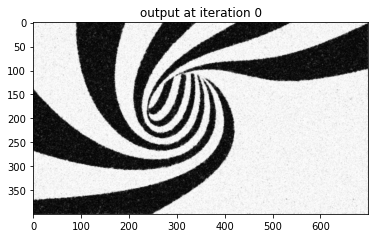

STEP :  1 Likelihood_average :  232063.8792079208


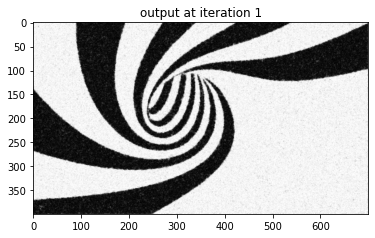

STEP :  2 Likelihood_average :  231983.09801980204


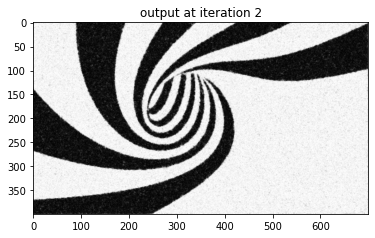

STEP :  3 Likelihood_average :  231996.77920792086


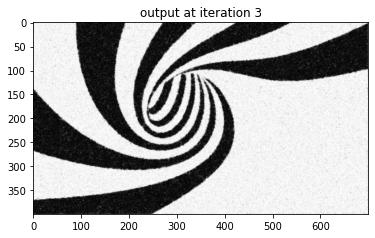

STEP :  4 Likelihood_average :  231980.40495049508


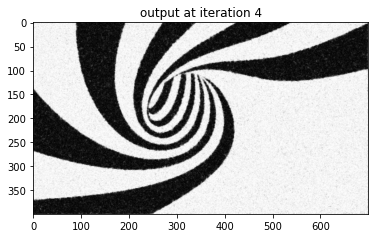

STEP :  5 Likelihood_average :  231984.10396039605


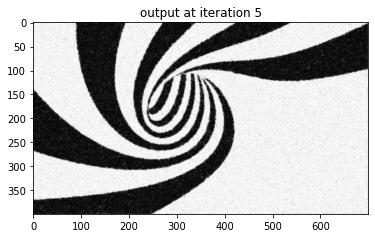

STEP :  6 Likelihood_average :  232011.19603960405


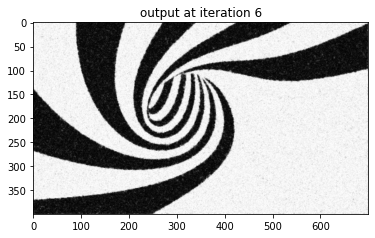

STEP :  7 Likelihood_average :  231975.43267326735


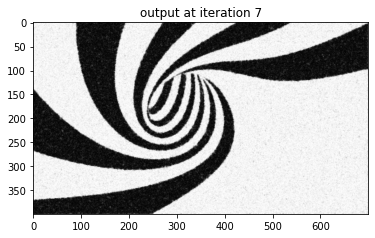

STEP :  8 Likelihood_average :  231990.57524752477


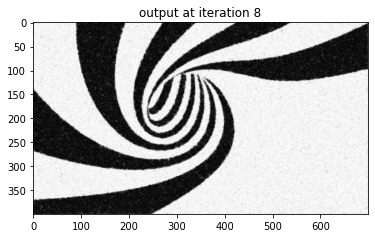

STEP :  9 Likelihood_average :  232013.77722772278


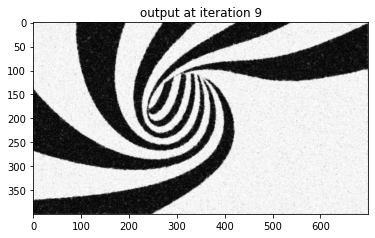

In [ ]:
from scipy.ndimage import shift
def compute_likelihood(X_chain, alpha, beta):
    shifted_right = shift(X_chain, [0, 0, 1], mode = 'constant', cval = -1)
    shifted_left = shift(X_chain, [0, 0, -1], mode = 'constant', cval = -1)
    shifted_down = shift(X_chain, [0, 1, 0], mode = 'constant', cval = -1)
    shifted_up = shift(X_chain, [0, -1, 0], mode = 'constant', cval = -1)
    interaction = (shifted_right == X_chain) + (shifted_left == X_chain) + (shifted_down == X_chain) + (shifted_up == X_chain)
    res = (alpha * X_chain + beta * interaction).sum(axis = (1, 2))
    return res

def expectation(X_chain):
    return X_chain.mean(axis = 0)

def maximization(proba_succes, y):
    mu_1 = (proba_succes * y).sum() / proba_succes.sum()
    mu_0 = ((1 - proba_succes) * y).sum() / (1 - proba_succes).sum()
    return mu_0, mu_1

def MCMC_EM(y, alpha, beta, mu_0_ini, mu_1_ini, burn_in, n_iter_mcmc, n_iter_em):
    mu_0 = mu_0_ini
    mu_1 = mu_1_ini
    for t in range(n_iter_em):
        distrib = Gibbs_sampling(burn_in, n_iter_mcmc, np.random.binomial(1, 0.5, (h, w)), noisy_img, mu_0 = mu_0, mu_1 = mu_1, alpha = alpha, beta = beta)
        likelihoods = compute_likelihood(distrib.copy(), alpha, beta)
        print("STEP : ", t, "Likelihood_average : ", likelihoods.mean())
        proba_succes = expectation(distrib)
        plt.imshow(proba_succes, cmap = 'gray', vmin = 0, vmax = 1)
        plt.title('output at iteration %s' % t)
        plt.show()
        mu_0, mu_1 = maximization(proba_succes, y)
    return mu_0, mu_1, proba_succes



mu_0, mu_1, proba_succes = MCMC_EM(y = noisy_img, alpha = 0.1, beta = 0.8, mu_0_ini = 0 , mu_1_ini = 1, burn_in = 100, n_iter_mcmc = 200, n_iter_em = 10)



0.06197365946428398 0.9721664305113112


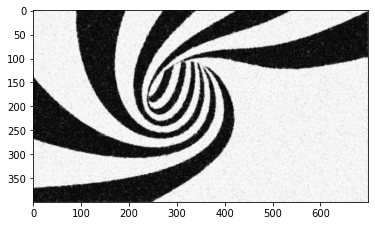

In [ ]:
print(mu_0, mu_1)
plt.imshow(proba_succes, cmap = 'gray');

The EM algorithm is pretty powerful, the parameters converge toward the best one. By choosing good parameters we achieve good results, the image is similar to the original one. 

However, there are a lot of hyper parameters like $\alpha$, $\beta$ but also the parameters of the sampling step (E-step) with the burn-in for example. 

Moreover, since we do not compute the real probabilities $\mathbb{P}_x(x_i|\theta_t, y)$, but we estimate them using gibbs sampling, there are no guaranties that the log-likelihood will increase at each step. We can just hope for it to increase on average.

## Question 4 : Prior on $\alpha$ and $\beta$
___

We now work with a Bayesian framework, we have a distribution prior on the parameters : $\theta = (\alpha, \beta, \mu_0, \mu_1)$. 

$$ \pi(\alpha, \beta, \mu_0, \mu_1) = \phi(\mu_0; m, s^2) \phi(\mu_1; m, s^2) \mathbb{1}_{[0;a]}(\alpha)\mathbb{1}_{[0;b]}(\beta)$$

We aim at sampling according to the joint distribution : $(x, \alpha, \beta, \mu_0, \mu_1)$ like in the question 2 with Gibbs sampling. We compute the conditional distributions of each parameters. 

$$p(x,\theta) \propto p(y|x, \theta) p(x|\theta)\pi(\theta)$$

$$p(x,\theta) \propto\exp\left\{- \sum_{i = 1}^n \left[\frac{1}{2}(y_i - \mu_{x_i})^2 - \alpha x_i - \beta \sum_{j \in \mathcal{N}(i)}\mathbb{1}(x_i = x_j) \right]\right\} \phi(\mu_0; m, s^2) \phi(\mu_1; m, s^2) \mathbb{1}_{[0;a]}(\alpha)\mathbb{1}_{[0;b]}(\beta)$$

We deduce that : 

$$p(\alpha|x, \beta, \mu_0, \mu_1) \propto \exp(\alpha\sum_{i=1}^n x_i)\mathbb{1}_{[0;a]}(\alpha)$$

The exact distribution is on $[0;a]$:

$$p(\alpha|x, \beta, \mu_0, \mu_1) = \mathbb{1}_{[0;a]}(\alpha)\frac{\exp(\alpha\sum_{i=1}^n x_i) \times \sum_{i=1}^n x_i}{\exp(a\sum_{i=1}^n x_i) - 1}$$

In order to sample according to this law, we use the inversion method therefore we compute the repartition function :

$$P(\alpha \leq z) = \begin{cases}
\frac{\exp(z\sum_{i=1}^n x_i) - 1}{\exp(a\sum_{i=1}^n x_i) - 1} & \text{if } z \in [0;a] \\
0  & \text{if } z \leq 0 \\
1  & \text{if } z \geq a

\end{cases}
$$

We inverse this function : 

$$z = \frac{1}{\sum_{i=1}^n x_i} \text{ln}(1 + u(\exp(a\sum_{i=1}^n x_i) - 1))$$

So in order to sample $\alpha$, we sample $u \sim \mathcal{U}([0;1])$ and the then return : $F^{-1}_{\alpha}(u) = \frac{1}{\sum_{i=1}^n x_i} \text{ln}(1 + u(\exp(a\sum_{i=1}^n x_i) - 1))$

The role of $\alpha$ and $\beta$ are quitte similar, so in order to sample from the conditional law of $\beta$ : we sample $u \sim \mathcal{U}([0;1])$ and return $F^{-1}_{\beta}(u) = \frac{1}{\sum_{(i,j)\in E} \mathbb{1}(x_i=x_j)} \text{ln}(1 + u(\exp(b\sum_{(i,j)\in E} \mathbb{1}(x_i=x_j)) - 1))$

Now we sample according the conditional $\mu_1$ : $(\mu_1|x, \alpha, \beta, \mu_0)$

We have : 

$$p(\mu_1|x, \alpha, \beta, \mu_0) \propto  \exp \left\{ -\frac{1}{2} \sum_{i=1}^n(y_i - \mu_1)^2 \mathbb{1}(x_i =1) - \frac{1}{2s^2}(m - \mu_1)^2\right\} $$

$$p(\mu_1|x, \alpha, \beta, \mu_0) \propto \exp \left\{-\frac{1}{2} \sum_{i=1}^n (y_i^2 - 2 \mu_1 y_i + \mu_1^2) x_i- \frac{1}{2s^2} (m^2 - 2m \mu_1 + \mu_1^2) \right\}$$


$$p(\mu_1|x, \alpha, \beta, \mu_0) \propto \exp \left\{ -\frac{1}{2} \right[ \mu_1^2(\sum_{i=1}^n x_i + \frac{1}{s^2}) - 2(\sum_{i=1}^n y_ix_i + \frac{m}{s^2}) \mu_1)\left]\right\}$$


$$p(\mu_1|x, \alpha, \beta, \mu_0) \propto \exp \left\{ -\frac{1}{2} (\sum_{i=1}^n x_i + \frac{1}{s^2}) (\mu_1 - \frac{\sum_{i=1}^n y_ix_i + \frac{m}{s^2}}{\sum_{i=1}^n x_i + \frac{1}{s^2}})^2\right\}$$

So :
$$\mu_1|x, \alpha, \beta, \mu_0 \sim \mathcal{N}(\frac{\sum_{i=1}^n y_ix_i + \frac{m}{s^2}}{\sum_{i=1}^n x_i + \frac{1}{s^2}},(\sum_{i=1}^n x_i + \frac{1}{s^2})^{-1})$$

$\mu_0$ and $\mu_1$ have a symetrical role so :

$$\mu_0|x, \alpha, \beta, \mu_1 \sim \mathcal{N}(\frac{\sum_{i=1}^n y_i(1-x_i) + \frac{m}{s^2}}{\sum_{i=1}^n(1- x_i) + \frac{1}{s^2}},(\sum_{i=1}^n (1-x_i) + \frac{1}{s^2})^{-1})$$

The sampling of $x|\alpha, \beta, \mu_0, \mu_1$ is done like in question 2, the difference here is that the hyper-parameters of question 2 become random variables so we sample them at each iteration of Gibbs sampling. 

alpha = 0.02999725036507965
beta = 1.4999863750917992
mu0 = 0.6084500182339172
mu1 = 0.9925099072531252


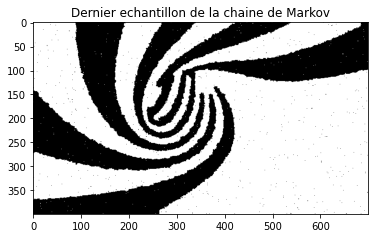

In [ ]:
@jit(nopython=True)
def logsumexp(a, axis=None, b=None):
    """Compute the log of the sum of exponentials of input elements.
    Parameters
    ----------
    """
    if b is not None:
        if np.any(b == 0):
            a = a + 0.  # promote to at least float
            a[b == 0] = -np.inf

    a_max = a.max()
    if not np.isfinite(a_max):
        a_max = 0

    if b is not None:
        b = np.asarray(b)
        tmp = b * np.exp(a - a_max)
    else:
        tmp = np.exp(a - a_max)
    s = np.sum(tmp)
    out = np.log(s)
    out += a_max
    return out


@jit(nopython=True)
def shift(key, array, direction, val):
    '''
    Function allowing to shift an array in a direction.
    key : number of pixel to shift
    array : array we need to shift
    direction : 'right','down','up','left'
    '''
    if key > 0:
        if direction == 'left':
            return np.concatenate((val * np.ones(array.shape, dtype=np.int8)[:,:key],array[:,:-key]),axis = 1)
        elif direction == 'right':
            return np.concatenate((array[:, key:], val * np.ones(array.shape, dtype=np.int8)[:,:key]),axis = 1)
        elif direction == 'up':
            return np.concatenate((val * np.ones(array.shape, dtype=np.int8)[:key,:],array[:-key,:]),axis = 0)
        elif direction == 'down':
            return np.concatenate((array[key:,:],val * np.ones(array.shape, dtype=np.int8)[:key,:]),axis = 0)
        # else:
        #     raise("Invalid Direction")
    else:
        return array

@jit(nopython=True)
def sigmoid(x):
  """
  Return the sigmoid of x
  """
  return 1 / (1 + np.exp(-x))

@jit(nopython=True)
def F_inv(u, cst, param):
    """
    Return the inverse function of the repartition function as specified previously
    """
    a = np.array([param*cst, 0, 0])
    b = np.array([u, -u, 1])
    return 1/cst * logsumexp(a, b=b)
    # return 1/cst * np.log(u*(np.exp(param*cst) - 1) + 1)

@jit(nopython=True)
def compute_neighbours(X):
    """
    Function computing the number of neighbours that are equal
    """
    shifted_right = shift(key = 1, array= X, direction='right', val = -1)
    shifted_left = shift(key = 1, array = X, direction='left', val = -1)
    shifted_down = shift(key = 1, array = X, direction='down', val = -1)
    shifted_up = shift(key = 1, array = X, direction='up', val = -1)
    interaction = (shifted_right == X) + (shifted_left == X) + (shifted_down == X) + (shifted_up == X)
    return np.sum(interaction)

@jit(nopython=True)
def sample_xi_all(y, x, alpha, beta, mu_0, mu_1, a, b, s, m):
    """
    Sample xi, alpha, beta, mu0, mu1
    """
    # sampling according to xi
    p = np.zeros((h, w))
    for i in range(h):
        for j in range(w):
            exp_term = 0.5*((y[i, j] - mu_0)**2 - (y[i, j] - mu_1)**2)
            if i == 0 and j == 0:
                factor = alpha + 2 * beta * (x[1, 0] + x[0, 1]  - 1)

            elif i == h-1 and j == 0:
                factor = alpha + 2 * beta * (x[h-2, 0] + x[h-1, 1]  - 1)

            elif i == 0 and j == w-1:
                factor = alpha + 2 * beta * (x[0, w-2] + x[1, w-1]  - 1)

            elif i == h-1 and j == w-1:
                factor = alpha + 2 * beta * (x[h-1, w-2] + x[h-2, w-1]  - 1)

            elif i==0:
              factor = alpha + 2 * beta * (x[i, j-1] + x[i, j+1] + x[i+1, j] - 3/2)

            elif i==h-1:
              factor = alpha + 2 * beta * (x[i, j-1] + x[i, j+1] + x[i-1, j] - 3/2)

            elif j==0:
              factor = alpha + 2 * beta * (x[i-1, j] + x[i+1, j] + x[i, j+1] - 3/2)

            elif j==w-1:
              factor = alpha + 2 * beta * (x[i-1, j] + x[i+1, j] + x[i, j-1] - 3/2)

            else:
              factor = alpha + 2 * beta * (x[i-1, j] + x[i+1, j] + x[i, j-1] + x[i, j+1] - 2)
            factor += exp_term
            p1 = sigmoid(factor)#* normal_matrix_1[i, j]
            p0 = sigmoid(-factor)# * normal_matrix_0[i, j]
            assert p1/(p0+p1) <= 1 and p1/(p0+p1) >= 0
            x[i, j] = np.random.binomial(1, p1/(p0+p1))

    # sampling according to alpha:
    u1 = np.random.rand()
    cst_alpha = np.sum(x)
    alpha = F_inv(u1, cst_alpha, a)
    assert 0 <= alpha and alpha <= a

    # sampling according to beta:
    u2 = np.random.rand()
    cst_beta = compute_neighbours(x)
    beta = F_inv(u2, cst_beta, b)
    assert 0<= beta and beta <= b

    # sampling according to mu0
    m0 = (np.sum(y*(1-x)) + m/s)/(h*w - cst_alpha + 1/s)
    s1 = 1/np.sqrt((h*w - cst_alpha + 1/s))
    mu_0 = np.random.normal(loc = m, scale = s)

    # sampling according to mu1:
    m1 = (np.sum(y*x) + m/s)/(cst_alpha + 1/s)
    s1 = 1/np.sqrt((cst_alpha + 1/s))
    mu_1 = np.random.normal(loc = m1, scale = s1)
    
    return alpha, beta, mu_0, mu_1, x

@jit(nopython=True)
def Gibbs_sampling_prior(burn_in, n_iter, h, w, alpha_0, beta_0, mu0_0, mu1_0, y, a, b, s, m):
    """
    Function returning the markov chain
    """
    # paramaters
    X_chain = np.empty((n_iter+1, h, w))
    alpha_chain = np.empty(n_iter)
    beta_chain = np.empty(n_iter)
    mu_0_chain = np.empty(n_iter)
    mu_1_chain = np.empty(n_iter)
    alpha = alpha_0
    beta = beta_0
    mu_1 = mu1_0
    mu_0 = mu0_0
    # X = X0.copy()
    X = (y.copy() > 1/2)*1

    # iterations
    for i in range(n_iter):
      alpha, beta, mu_0, mu_1, X= sample_xi_all(y, X, alpha, beta, mu_0, mu_1, a, b, s, m)
      X_chain[i+1] = X
      alpha_chain[i] = alpha
      beta_chain[i] = beta
      mu_0_chain[i] = mu_0
      mu_1_chain[i] = mu_1
    return X_chain[burn_in+1:], alpha_chain[burn_in:], beta_chain[burn_in:], mu_0_chain[burn_in:], mu_1_chain[burn_in:]


# Definition des priors
a=0.03
b = 1.5
s=0.1
m=0.5

# Initialisation des paramètres
alpha = a
beta = b
mu0 = np.random.rand()
mu1 = mu0 + np.random.rand()

# Calcul de la chaine
X_chain, alpha_chain, beta_chain, mu_0_chain, mu_1_chain = Gibbs_sampling_prior(0, 500, h, w, alpha, beta, mu0, mu1, noisy_img, a=a, b = b, s=s, m=m)
plt.imshow(X_chain[-1], cmap = 'gray')
plt.title('Dernier echantillon de la chaine de Markov');
print('alpha =', alpha_chain[-1])
print('beta =', beta_chain[-1])
print('mu0 =', mu_0_chain[-1])
print('mu1 =', mu_1_chain[-1])

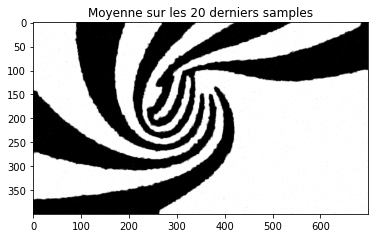

In [ ]:
plt.imshow(np.mean(X_chain[-20:], axis = 0), cmap = 'gray', vmin = 0, vmax = 1)
plt.title('Moyenne sur les 20 derniers samples');

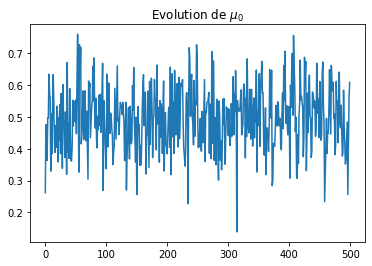

In [ ]:
plt.plot(mu_0_chain)
plt.title('Evolution de $\mu_0$');

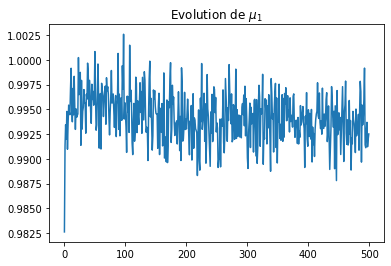

In [ ]:
plt.plot(mu_1_chain)
plt.title('Evolution de $\mu_1$');

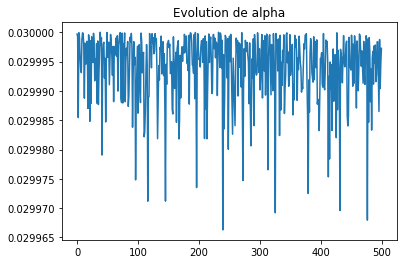

In [ ]:
plt.plot(alpha_chain)
plt.title('Evolution de alpha');

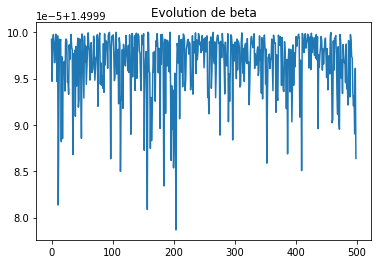

In [ ]:
plt.plot(beta_chain)
plt.title('Evolution de beta');

We observe that the coefficients $\mu_0$ and $\mu_1$ don't evolve a lot. We notice that $\mu_1$ converges towards 1. The resulting image is not really great, mainly at the center where the structure of the spiral is quitte thin. However with a prior on the model parameters we achieve good results overall. We could add a second mean prior for the two parameters $\mu_1$ and $\mu_2$ in order to add some knowledge about the image (black and white one). The main drawback of this approach is the dependency of the hyper-parameters, we observed that if we choose bad values, like a too big, we obtain very poors results.